In [111]:
import os
import json
import cv2
import numpy as np
from skimage.color import label2rgb
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model


In [112]:
import cv2
import numpy as np
import json

def load_images_and_masks(image_paths, json_paths, image_size=(256, 256), point_size=3):
    images = []
    masks = []

    for img_path, json_path in zip(image_paths, json_paths):
        img = cv2.imread(img_path)
        img = img / 255
        original_size = img.shape[:2] 
        img = cv2.resize(img, image_size)
        images.append(img)

       
        mask = np.zeros((image_size[0], image_size[1], 4), dtype=np.uint8)
        mask[:, :, 0] = 1 

        try:
            with open(json_path, 'r') as f:
                json_data = json.load(f)
        except Exception as e:
            print(f"Błąd odczytu JSON {json_path}: {e}")
            continue  

        if not isinstance(json_data, list):
            print(f"Nieprawidłowy format JSON w {json_path}, oczekiwano listy!")
            continue

        for item in json_data:
            if 'x' in item and 'y' in item and 'label_id' in item:
                x, y, label = int(item['x']), int(item['y']), int(item['label_id'])

                x = int((x / original_size[1]) * image_size[1])
                y = int((y / original_size[0]) * image_size[0])

                if 0 <= x < image_size[1] and 0 <= y < image_size[0]: 
                    if label == 1:
                        cv2.circle(mask, (x, y), point_size, (0, 1, 0, 0), -1)  
                    elif label == 2:
                        cv2.circle(mask, (x, y), point_size, (0, 0, 1, 0), -1)  
                    elif label == 3:
                        cv2.circle(mask, (x, y), point_size, (0, 0, 0, 1), -1)  

        
        mask[:, :, 0] = (np.sum(mask[:, :, 1:], axis=-1) == 0).astype(np.uint8)

        masks.append(mask)

    return np.array(images), np.array(masks, dtype=np.float32)


def load_files(path):
    images = []
    jsons = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith(('.jpg', '.png')):
                images.append(os.path.join(root, file))
            elif file.endswith('.json'):
                jsons.append(os.path.join(root, file))
    return images, jsons

In [113]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    return x

def max_pool(x):
    return layers.MaxPooling2D((2, 2))(x)

def upsample_block(x, skip, filters):
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(filters, (2, 2), activation='relu', padding='same')(x)
    x = layers.concatenate([x, skip])
    x = conv_block(x, filters)
    return x


In [114]:
def unet(input_shape=(256, 256, 3), output_channels=4, filterd_vector=[32, 64, 128, 256, 512]):
    inputs = layers.Input(input_shape)

    conv1 = conv_block(inputs, filterd_vector[0])
    pool1 = max_pool(conv1)

    conv2 = conv_block(pool1, filterd_vector[1])
    pool2 = max_pool(conv2)

    conv3 = conv_block(pool2, filterd_vector[2])
    pool3 = max_pool(conv3)

    conv4 = conv_block(pool3, filterd_vector[3])
    pool4 = max_pool(conv4)

    conv5 = conv_block(pool4, filterd_vector[4])

    up6 = upsample_block(conv5, conv4, filterd_vector[3])
    up7 = upsample_block(up6, conv3, filterd_vector[2])
    up8 = upsample_block(up7, conv2, filterd_vector[1])
    up9 = upsample_block(up8, conv1, filterd_vector[0])

    outputs = layers.Conv2D(output_channels, (1, 1), activation='softmax')(up9)

    model = models.Model(inputs, outputs)
    return model

In [115]:
train_images_paths, train_json = load_files('SHIDC-B-Ki-67/bare images/Train')
test_images_paths, test_json = load_files('SHIDC-B-Ki-67/bare images/Test')
X_train, Y_train = load_images_and_masks(train_images_paths, train_json)
X_test, Y_test = load_images_and_masks(test_images_paths, test_json)
X_train_final, X_val, Y_train_final, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)

print(f"Dane treningowe: obrazy {X_train.shape}, maski {Y_train.shape}")
print(f"Dane testowe: obrazy {X_test.shape}, maski {Y_test.shape}")



Dane treningowe: obrazy (1656, 256, 256, 3), maski (1656, 256, 256, 4)
Dane testowe: obrazy (700, 256, 256, 3), maski (700, 256, 256, 4)


In [116]:
model_dir = "best_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [117]:
pred_mask_dir = "predicted_masks"
if not os.path.exists(pred_mask_dir):
    os.makedirs(pred_mask_dir)

model = unet(output_channels=4, filterd_vector=[64, 128, 256, 512, 1024])
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    filepath=os.path.join(model_dir, "unet_best_model.h5"),  
    monitor="val_accuracy",  
    save_best_only=True,  
    mode="max",  
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_loss",  
    patience=10, 
    restore_best_weights=True,  
    verbose=1
)

history = model.fit(
    X_train_final, Y_train_final,
    epochs=50, batch_size=24,
    validation_data=(X_val, Y_val),
    callbacks=[checkpoint, early_stopping]
)

K.clear_session() 

Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.9527
Epoch 1: val_accuracy improved from -inf to 0.97128, saving model to best_model\unet_best_model.h5
56/56 [==============================] - 101s 1s/step - loss: 0.2045 - accuracy: 0.9527 - val_loss: 0.0699 - val_accuracy: 0.9713
Epoch 2/50
56/56 [==============================] - ETA: 0s - loss: 0.0697 - accuracy: 0.9696
Epoch 2: val_accuracy did not improve from 0.97128
56/56 [==============================] - 53s 941ms/step - loss: 0.0697 - accuracy: 0.9696 - val_loss: 0.0649 - val_accuracy: 0.9713
Epoch 3/50
56/56 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9696
Epoch 3: val_accuracy did not improve from 0.97128
56/56 [==============================] - 53s 941ms/step - loss: 0.0647 - accuracy: 0.9696 - val_loss: 0.0594 - val_accuracy: 0.9713
Epoch 4/50
56/56 [==============================] - ETA: 0s - loss: 0.0565 - accuracy: 0.9696
Epoch 4: val_accuracy did not

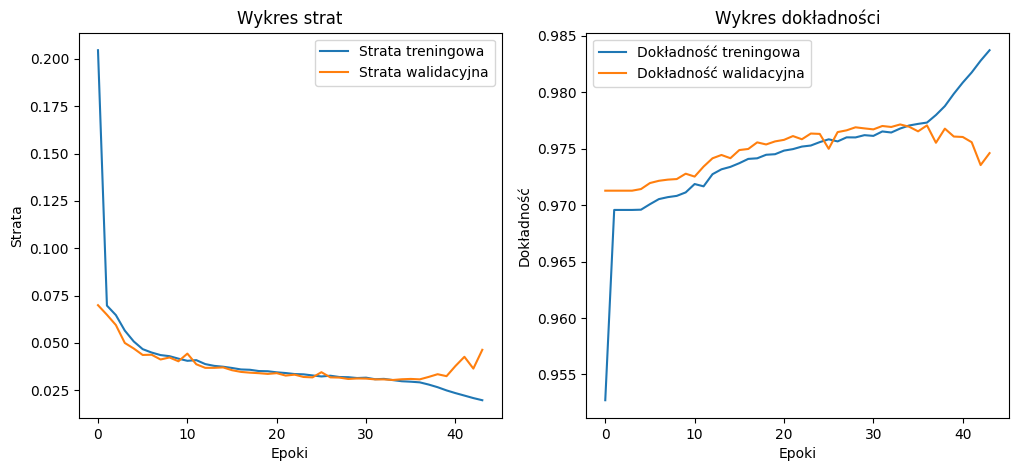

In [118]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.title('Wykres strat')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Dokładność treningowa')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.title('Wykres dokładności')
plt.legend()

plt.show()

1/1 [==============================] - 0s 14ms/step


Text(0.5, 1.0, 'Prawdziwa maska')

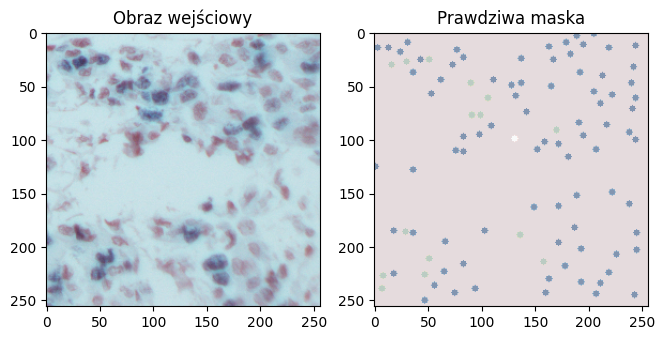

In [130]:
idx = random.randint(0, len(X_test) - 1)
test_img = X_test[idx:idx+1]  
true_mask = Y_test[idx] 
pred_mask = model.predict(test_img)[0]
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_img[0])
plt.title("Obraz wejściowy")
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='Reds', alpha=0.5) 
plt.imshow(true_mask[:, :, 1], cmap='Greens', alpha=0.5)
plt.imshow(true_mask[:, :, 2], cmap='Blues', alpha=0.5)  
plt.title("Prawdziwa maska")


1/1 [==============================] - 0s 15ms/step


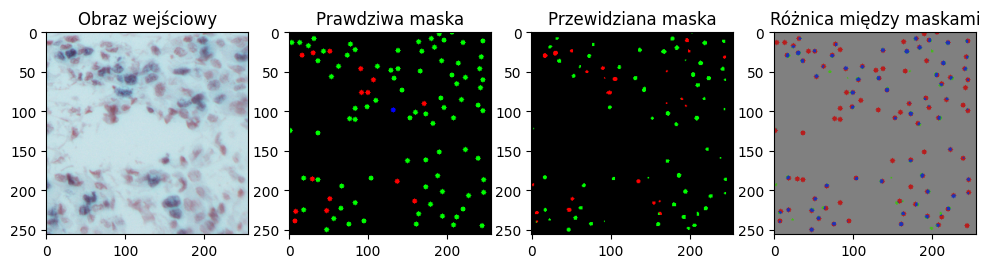

In [131]:
import random
import os
import cv2
import numpy as np
from skimage.color import label2rgb
import matplotlib.pyplot as plt

custom_colors = {
    0: [0, 0, 0],  # Tło - czarny
    1: [255, 0, 0], # Pozytywne - czerwony
    2: [0, 255, 0], # Negatywne - zielony
    3: [0, 0, 255]  # TIL - niebieski 
}

def compute_mask_difference(true_mask, pred_mask):
    diff_mask = np.zeros((*true_mask.shape, 3), dtype=np.uint8)

    true_mask_bin = (true_mask > 0).astype(np.uint8)
    pred_mask_bin = (pred_mask > 0).astype(np.uint8)

    # False Positives – Model przewidział, ale nie ma w ground truth (Zielony)
    diff_mask[(true_mask_bin == 0) & (pred_mask_bin == 1)] = [71, 183, 29]

    # False Negatives – Model nie przewidział, ale ground truth istnieje (Czerwony)
    diff_mask[(true_mask_bin == 1) & (pred_mask_bin == 0)] = [183, 29, 29]

    # True Positives – Model dobrze przewidział (Niebieski)
    diff_mask[(true_mask_bin == 1) & (pred_mask_bin == 1)] = [29, 50, 183]

    # Tło – jeśli żaden z warunków nie został spełniony, ustaw szary kolor
    diff_mask[(true_mask_bin == 0) & (pred_mask_bin == 0)] = [128, 128, 128]

    return diff_mask

def apply_custom_colors(mask, colors):
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for label, color in colors.items():
        colored_mask[mask == label] = color
    return colored_mask


test_img = X_test[idx:idx+1]  
true_mask = np.argmax(Y_test[idx], axis=-1)
pred_mask = np.argmax(model.predict(test_img)[0], axis=-1)


true_mask_colored = apply_custom_colors(true_mask, custom_colors)
pred_mask_colored = apply_custom_colors(pred_mask, custom_colors)
mask_diff_colored = compute_mask_difference(true_mask, pred_mask)

plt.figure(figsize=(12, 5))

plt.subplot(1, 4, 1)
plt.imshow(test_img[0])
plt.title("Obraz wejściowy")

plt.subplot(1, 4, 2)
plt.imshow(true_mask_colored)
plt.title("Prawdziwa maska")

plt.subplot(1, 4, 3)
plt.imshow(pred_mask_colored)
plt.title("Przewidziana maska")

plt.subplot(1, 4, 4)
plt.imshow(mask_diff_colored)
plt.title("Różnica między maskami")
plt.show()


In [132]:
def test_model_performance(model, X_test, Y_test):

    Y_pred = model.predict(X_test)

    Y_pred_labels = np.argmax(Y_pred, axis=-1)  
    Y_test_labels = np.argmax(Y_test, axis=-1) 

    num_classes = Y_test.shape[-1]
    class_names = ["Tło", "Pozytywne", "Negatywne", "TIL" ]
    if num_classes != len(class_names):
        class_names = [f"Klasa {i}" for i in range(num_classes)]

    iou_scores = []
    for class_idx in range(num_classes):
        intersection = np.logical_and(Y_test_labels == class_idx, Y_pred_labels == class_idx).sum()
        union = np.logical_or(Y_test_labels == class_idx, Y_pred_labels == class_idx).sum()
        iou = intersection / union if union > 0 else 0
        iou_scores.append(iou)

    correct_classifications = np.sum(Y_test_labels == Y_pred_labels)
    total_pixels = np.prod(Y_test_labels.shape)
    classification_accuracy = correct_classifications / total_pixels

    print("\nWyniki modelu na zbiorze testowym:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: IoU = {iou_scores[i] * 100:.2f}%")

    print(f"\nOgólna dokładność klasyfikacji: {classification_accuracy * 100:.2f}%")

    return iou_scores, classification_accuracy

my_model = load_model("./best_model/unet_best_model.h5")
iou_results, accuracy = test_model_performance(my_model, X_test, Y_test)


22/22 [==============================] - 7s 336ms/step

Wyniki modelu na zbiorze testowym:
Tło: IoU = 97.53%
Pozytywne: IoU = 39.35%
Negatywne: IoU = 28.60%
TIL: IoU = 0.00%

Ogólna dokładność klasyfikacji: 97.54%


In [133]:
from skimage.measure import label, regionprops

def calculate_iou_objects(true_mask, pred_mask):

    
    results = {
        "IoU": {},
        "Detected Cells": {},
        "False Positives": {},
        "False Negatives": {},
        "True Positives": {}
    }

    unique_classes = np.unique(true_mask)
    unique_classes = unique_classes[unique_classes > 0]

    for class_id in unique_classes:

        true_class_mask = (true_mask == class_id).astype(np.uint8)
        pred_class_mask = (pred_mask == class_id).astype(np.uint8)

        true_labeled = label(true_class_mask) 
        pred_labeled = label(pred_class_mask) 
      
        true_regions = regionprops(true_labeled)
        pred_regions = regionprops(pred_labeled)

        total_true_cells = len(true_regions) 
        total_pred_cells = len(pred_regions)  

        matched_cells = 0
        false_positives = 0
        false_negatives = total_true_cells 
        intersection = 0
        union = 0

        for pred_region in pred_regions:
            pred_single_cell = (pred_labeled == pred_region.label)

            match_found = False  

            for true_region in true_regions:
                true_single_cell = (true_labeled == true_region.label)

                
                inter = np.logical_and(true_single_cell, pred_single_cell).sum()
                uni = np.logical_or(true_single_cell, pred_single_cell).sum()

                if inter > 0:  
                    matched_cells += 1
                    intersection += inter
                    union += uni
                    false_negatives -= 1  
                    match_found = True

            if not match_found:
                false_positives += 1  


        iou = (intersection / union) * 100 if union > 0 else 0
        results["IoU"][class_id] = iou
        results["Detected Cells"][class_id] = matched_cells
        results["False Positives"][class_id] = false_positives
        results["False Negatives"][class_id] = false_negatives
        results["True Positives"][class_id] = matched_cells  

    return results


In [134]:
results = calculate_iou_objects(true_mask, pred_mask)


def print_iou_results(results):
    print("\nWyniki detekcji komórek:\n")
    print(f"{'Klasa':<10} {'IoU (%)':<10} {'TP':<10} {'FP':<10} {'FN':<10}")
    print("-" * 50)

    for class_id in results["IoU"]:
        iou = results["IoU"][class_id]
        tp = results["True Positives"][class_id]
        fp = results["False Positives"][class_id]
        fn = results["False Negatives"][class_id]
        print(f"{class_id:<10} {iou:<10.2f} {tp:<10} {fp:<10} {fn:<10}")

print_iou_results(results)



Wyniki detekcji komórek:

Klasa      IoU (%)    TP         FP         FN        
--------------------------------------------------
1          44.40      14         10         1         
2          47.04      56         5          26        
3          0.00       0          0          1         
